# Unbalanced Decision tree - dataset: echo_popul.csv
## Task: Song popularity prediction

In [77]:
%matplotlib inline
 
import pandas as pd
import numpy as np

# sklearn modules 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px

import matplotlib.pyplot as plt
from random import randint

import warnings
warnings.filterwarnings('ignore')


In [27]:
echo_popul = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/clean_datasets/echo_popul.csv')
echo_popul.set_index('track_id', inplace=True)
echo_popul.head()

,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,listens,duration,bit_rate,comments,interest,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,popularity
track_id,,,,,,,,,,,,,,,,,,
2,0.388990,0.386740,0.406370,0.000000,1293,168,256000,0,4656,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,not popular
3,0.388990,0.386740,0.406370,0.000000,514,237,256000,0,1470,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,not popular
5,0.388990,0.386740,0.406370,0.000000,1151,206,256000,0,1933,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,not popular
10,0.557339,0.614272,0.798387,0.005158,50135,161,192000,0,54881,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,popular
134,0.388990,0.386740,0.406370,0.000000,943,207,256000,0,1126,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,not popular


In [40]:
# encoding labels: 0 --> not popular,  1 --> popular
le = preprocessing.LabelEncoder()
echo_popul['popularity'] = le.fit_transform(echo_popul['popularity'])

In [49]:
echo_popul['popularity'].value_counts()

0    12375
1      754
Name: popularity, dtype: int64

In [50]:
popul_labels = echo_popul['popularity']
echo_popul.drop('popularity', axis=1, inplace=True)

In [54]:
# shuffle and split into development set and internal test set
X_develop, X_test, y_develop, y_test = train_test_split(
echo_popul, popul_labels, test_size=0.30, random_state=42)

In [55]:
# check partition 
print(f"____Legend____\n0: not popular\n1: popular\n\nDevelopment set:\
\n{y_develop.value_counts()}\n\nInternal Test:\n{y_test.value_counts()}")

____Legend____
0: not popular
1: popular

Development set:
0    8665
1     525
Name: popularity, dtype: int64

Internal Test:
0    3710
1     229
Name: popularity, dtype: int64


In [59]:
# normalize data
scaler = StandardScaler(copy=False)
X_develop = scaler.fit_transform(X_develop)
X_test = scaler.transform(X_test)

# Feature selection - SFS

This Sequential Feature Selector adds (forward selection) or removes (backward selection) features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

This approach is needed as we are dealing with a dataset with 17 dimension.
After doing a feature selection we are able to discriminate the classes (as shown in the PCA-scatter plot) 

In [122]:
tree = DecisionTreeClassifier() 
sfs = SFS(tree, 
           k_features=6, 
           forward=True, # if forward = True then SFS otherwise SBS
           floating=False, 
           verbose=2,
           scoring='accuracy'
           )
#after applying sfs fit the data:
sfs.fit(X_develop, y_develop)
sfs.k_feature_names_ 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.4s finished

[2021-02-27 20:15:26] Features: 1/6 -- score: 0.9712731229597388[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished

[2021-02-27 20:15:27] Features: 2/6 -- score: 0.977366702937976[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished

[2021-02-27 20:15:28] Features: 3/6 -- score: 0.977366702937976[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 ou

('0', '2', '3', '6', '7', '9')

In [133]:
print(f"Selected fetures:\n{echo_popul.iloc[:,[0,2,3,6,7,9]].columns.tolist()}")

Selected fetures:
['artist_discovery', 'artist_hotttnesss', 'song_currency', 'bit_rate', 'comments', 'acousticness']


## PCA

In [119]:
# 2D PCA
pca = PCA(n_components=2)
pca.fit(X_develop[:,[0,2,3,6,7,9]])
X_pca = pca.transform(X_develop[:,[0,2,3,6,7,9]])

In [120]:
X_pca.shape

(9190, 2)

No handles with labels found to put in legend.


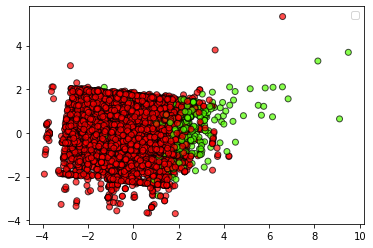

In [134]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_develop, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.legend()
plt.show()

In [140]:
# 3D PCA 
pca = PCA(n_components=3)
components = pca.fit_transform(X_develop[:,[0,2,3,6,7,9]])

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y_develop,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

## Model selection: 
The parameters of the model are obtained after performing a stratified 10 fold cross validation through a coarse grid search

In [64]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [65]:
param_grid = {
               "max_depth": [3,4,5,6, None],
               "min_samples_leaf": [25,45,75,150,250,300],
               "criterion": ["gini", "entropy"]
             }
# model
dtc = DecisionTreeClassifier()
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
random_search = GridSearchCV(dtc, cv =stratified_cv , param_grid=param_grid, n_jobs=2)

random_search.fit(X_develop, y_develop)
dtc=random_search.best_estimator_
report(random_search.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.980 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 25}

Model with rank: 2
Mean validation score: 0.979 (std: 0.004)
Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 25}

Model with rank: 2
Mean validation score: 0.979 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 45}

Model with rank: 2
Mean validation score: 0.979 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 75}

Model with rank: 2
Mean validation score: 0.979 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 150}

Model with rank: 2
Mean validation score: 0.979 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 250}

Model with rank: 2
Mean validation score: 0.979 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 300}

Model with rank: 2
Mean valida

Accuracy 0.9796902767199797
F1-score [0.98922704 0.82300885]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3710
           1       0.83      0.81      0.82       229

    accuracy                           0.98      3939
   macro avg       0.91      0.90      0.91      3939
weighted avg       0.98      0.98      0.98      3939



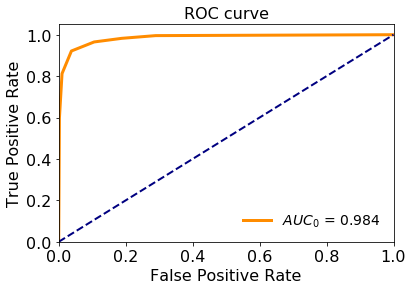

In [127]:
# unbalanced decision tree
dtc = DecisionTreeClassifier(criterion= 'gini',max_depth=3, min_samples_leaf= 25)
dtc.fit(X_develop[:,[0,2,3,6,7,9]],y_develop)

y_pred = dtc.predict(X_test[:,[0,2,3,6,7,9]])

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = dtc.predict_proba(X_test[:,[0,2,3,6,7,9]])
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

[[8571   94]
 [  88  437]]


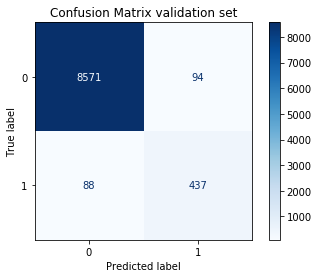

In [67]:
# confusion matrix
cm = plot_confusion_matrix(dtc,X_develop,y_develop,
                            cmap = plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix validation set')
print(cm.confusion_matrix)
plt.show()